In [22]:
import pandas as pd
import numpy as np
import json
import os
from datetime import datetime, timedelta
from sklearn.metrics import roc_auc_score
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных о просрочках
delqs_df = pd.read_parquet('D:/Anna/практика альфа-банк/deal_delqs_logs.pq')

# Обработка JSON файлов
def process_jsons(json_dir):
    data = []
    for filename in os.listdir(json_dir):
        if filename.endswith('.json'):
            with open(os.path.join(json_dir, filename), 'r') as f:
                record = json.load(f)
                if record['modelID'] == 'pd-auto-online':
                    # Извлекаем необходимые скоры
                    values = record['values']
                    internal_score = values.get('internal_model_score')
                    external_score = values.get('external_model_score')
                    final_score = values.get('final_model_score')
                    
                    if final_score is None and internal_score is not None and external_score is not None:
                        final_score = internal_score * 0.8 + external_score * 0.2
                    
                    data.append({
                        'requestID': record['requestID'],
                        'eventTime': record['eventTime'],
                        'loanID': record['loanID'],
                        'internal_model_score': internal_score,
                        'external_model_score': external_score,
                        'final_model_score': final_score
                    })
    return pd.DataFrame(data)

scoring_df = process_jsons('D:/Anna/практика альфа-банк/jsons')

# Формирование флага дефолта
def create_default_flag(scoring_df, delqs_df):
    result_df = scoring_df.copy()
    result_df['eventTime'] = pd.to_datetime(result_df['eventTime'])
    # Дата окончания 4х-месячного периода
    result_df['four_months_later'] = result_df['eventTime'] + pd.DateOffset(months=4)
    merged_df = result_df.merge(delqs_df, left_on='loanID', right_on='loan_id', how='left')
    # Даты просрочек
    merged_df['period_start_date'] = pd.to_datetime(merged_df['period_start_date'])
    merged_df['period_end_date'] = pd.to_datetime(merged_df['period_end_date'])
    # Длительность просрочки
    merged_df['delq_duration'] = (merged_df['period_end_date'] - merged_df['period_start_date']).dt.days
    # Флаг дефолта
    def is_default(row):
        if pd.isna(row['period_start_date']):
            return 0
        
        # Проверка, что просрочка началась в течение 4 месяцев после скоринга и длилась не менее 30 дней
        if (row['period_start_date'] <= row['four_months_later'] and row['delq_duration'] >= 30):
            return 1
        return 0
    
    merged_df['default_flag'] = merged_df.apply(is_default, axis=1)
    
    # Группировка по заявкам
    final_df = merged_df.groupby('loanID').agg({
        'eventTime': 'first',
        'internal_model_score': 'first',
        'external_model_score': 'first',
        'final_model_score': 'first',
        'default_flag': 'max'
    }).reset_index()
    
    return final_df

# Финальный датафрейм
final_df = create_default_flag(scoring_df, delqs_df)

In [24]:
final_df.head()

,loanID,eventTime,internal_model_score,external_model_score,final_model_score,default_flag
0,CAR2024010100b7,2024-01-01 08:21:16.498,0.01,0.010000,0.010000,0
1,CAR202401010141,2024-01-01 23:07:24.580,0.01,0.048278,0.017656,0
2,CAR2024010102a3,2024-01-01 23:53:16.245,0.05,0.090947,0.058189,0
3,CAR202401010394,2024-01-01 01:30:10.652,0.10,0.230000,0.126000,0
4,CAR202401010396,2024-01-01 12:04:33.036,0.02,0.081801,0.032360,0


In [26]:
# Функция расчета Gini из ROC AUC
def calculate_gini(y_true, y_score):
    try:
        # Проверка на пропуски
        mask = ~np.isnan(y_score)
        y_true_clean = y_true[mask]
        y_score_clean = y_score[mask]
        
        if len(y_true_clean) == 0:
            return np.nan
        
        if len(np.unique(y_true_clean)) < 2:
            return np.nan
            
        auc = roc_auc_score(y_true_clean, y_score_clean)
        return 2 * auc - 1
    except Exception as e:
        print(f"Ошибка при расчете Gini: {e}")
        return np.nan
# Расчет доверительного интервала методом бутстрепа
def bootstrap_confidence_interval(data, target, score, n_iterations=1000, sample_frac=0.7):
    gini_values = []
    
    for _ in range(n_iterations):
        # Формирование подвыборки
        sample = data.sample(frac=sample_frac, replace=True)
        if len(sample[target].unique()) < 2:
            continue  
        gini = calculate_gini(sample[target], sample[score])
        if not np.isnan(gini):
            gini_values.append(gini)
    if len(gini_values) == 0:
        return np.nan, np.nan
    lower = np.percentile(gini_values, 2.5)
    upper = np.percentile(gini_values, 97.5)
    
    return lower, upper

# Добавление месяца для группировки
final_df['month'] = final_df['eventTime'].dt.to_period('M')
# Расчет метрик по месяцам
monthly_metrics = []
for month in final_df['month'].unique():
    month_data = final_df[final_df['month'] == month]
    if len(month_data) < 10 or month_data['default_flag'].nunique() < 2:
        continue
    # Расчет Gini для всех скоров
    gini_internal = calculate_gini(month_data['default_flag'], month_data['internal_model_score'])
    gini_external = calculate_gini(month_data['default_flag'], month_data['external_model_score'])
    gini_final = calculate_gini(month_data['default_flag'], month_data['final_model_score'])
    # Доверительный интервал для финального скора
    ci_lower, ci_upper = bootstrap_confidence_interval(month_data, 'default_flag', 'final_model_score')
    # Аплифт от внешнего скора
    uplift = gini_final - gini_internal
    monthly_metrics.append({
        'month': month,
        'gini_internal': gini_internal,
        'gini_external': gini_external,
        'gini_final': gini_final,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'uplift': uplift,
        'n_obs': len(month_data),
        'default_rate': month_data['default_flag'].mean()
    })

metrics_df = pd.DataFrame(monthly_metrics)

In [28]:
metrics_df.head()

,month,gini_internal,gini_external,gini_final,ci_lower,ci_upper,uplift,n_obs,default_rate
0,2024-01,0.476789,0.263024,0.505326,0.455185,0.553323,0.028536,8773,0.069873
1,2024-02,0.482287,0.225679,0.495358,0.438507,0.551249,0.013071,8208,0.063596
2,2024-03,0.472437,0.240456,0.495311,0.444269,0.544710,0.022874,8916,0.072790
3,2024-04,0.453865,0.207090,0.471593,0.416990,0.523294,0.017728,8549,0.068780
4,2024-05,0.496403,0.196289,0.498285,0.449618,0.542302,0.001882,8900,0.070000


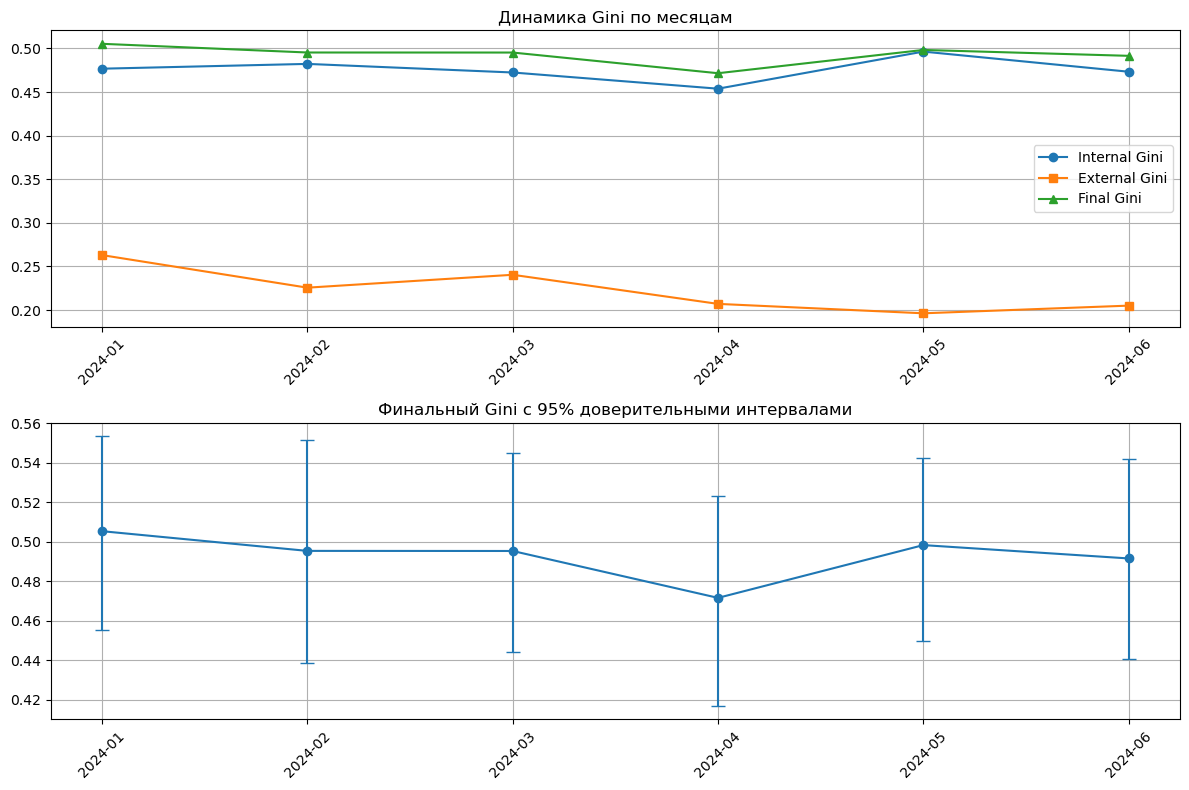

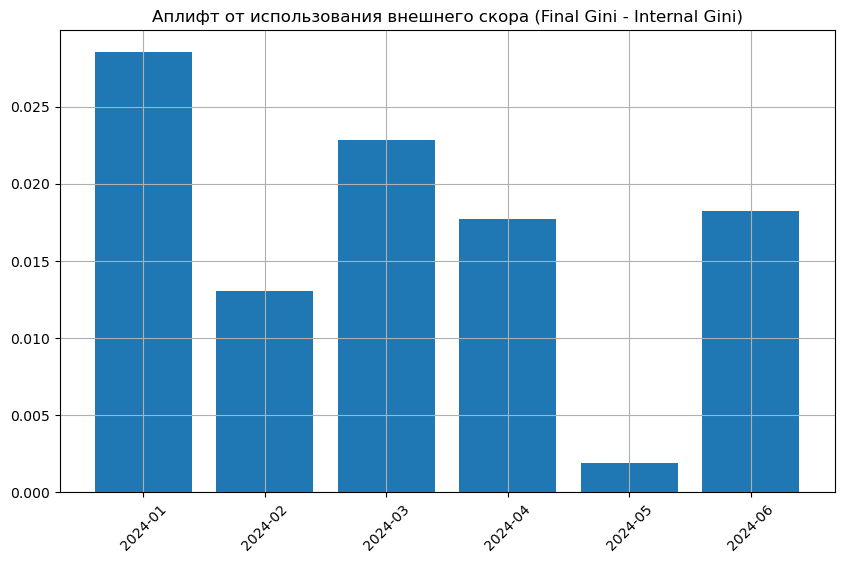

In [30]:
import matplotlib.pyplot as plt

# Визуализация Gini по месяцам
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(metrics_df['month'].astype(str), metrics_df['gini_internal'], marker='o', label='Internal Gini')
plt.plot(metrics_df['month'].astype(str), metrics_df['gini_external'], marker='s', label='External Gini')
plt.plot(metrics_df['month'].astype(str), metrics_df['gini_final'], marker='^', label='Final Gini')
plt.title('Динамика Gini по месяцам')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Доверительные интервалы для финального Gini
plt.subplot(2, 1, 2)
plt.errorbar(metrics_df['month'].astype(str), metrics_df['gini_final'], 
             yerr=[metrics_df['gini_final'] - metrics_df['ci_lower'], 
                   metrics_df['ci_upper'] - metrics_df['gini_final']],
             marker='o', capsize=5)
plt.title('Финальный Gini с 95% доверительными интервалами')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

# Аплифт от внешнего скора
plt.figure(figsize=(10, 6))
plt.bar(metrics_df['month'].astype(str), metrics_df['uplift'])
plt.title('Аплифт от использования внешнего скора (Final Gini - Internal Gini)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [32]:
# Анализ результатов
mean_gini_final = metrics_df['gini_final'].mean()
mean_uplift = metrics_df['uplift'].mean()

print("Результаты анализа")
print(f"Средний Gini финальной модели: {mean_gini_final:.3f}")
print(f"Средний аплифт от внешнего скора: {mean_uplift:.3f}")

if mean_gini_final < 0.35:
    quality_color = "Красный"
    quality_desc = "низкое качество"
elif mean_gini_final < 0.50:
    quality_color = "Жёлтый" 
    quality_desc = "удовлетворительное качество"
else:
    quality_color = "Зелёный"
    quality_desc = "высокое качество"

print(f"\nКачество модели: {quality_color} ({quality_desc})")

# Оценка эффективности внешнего скора
if mean_uplift > 0:
    print("Использование внешнего скора оправдано - положительный аплифт")
else:
    print("Использование внешнего скора не оправдано - отрицательный аплифт")

# Оценка стабильности модели
gini_std = metrics_df['gini_final'].std()
print(f"Стабильность модели (std Gini): {gini_std:.3f}")
if gini_std < 0.05:
    print("Модель демонстрирует стабильное качество")
else:
    print("Качество модели варьируется между месяцами")

print(f"\nДополнительная информация:")
print(f"- Количество месяцев анализа: {len(metrics_df)}")
print(f"- Средний дефолт-рейт: {metrics_df['default_rate'].mean():.3f}")
print(f"- Диапазон Gini финальной модели: [{metrics_df['gini_final'].min():.3f}, {metrics_df['gini_final'].max():.3f}]")

Результаты анализа
Средний Gini финальной модели: 0.493
Средний аплифт от внешнего скора: 0.017

Качество модели: Жёлтый (удовлетворительное качество)
Использование внешнего скора оправдано - положительный аплифт
Стабильность модели (std Gini): 0.011
Модель демонстрирует стабильное качество

Дополнительная информация:
- Количество месяцев анализа: 6
- Средний дефолт-рейт: 0.069
- Диапазон Gini финальной модели: [0.472, 0.505]
